利用集成算法进行Kaggle竞赛
===

# 1.概述
集成(ensemble)正在迅速成为应用机器学习最热门和流行的方法。目前，几乎每一个Kaggle冠军的解决方案都使用了集成，很多数据科学pipeline也使用集成。简单来说，集成把不同模型的预测结果结合起来，生成最终预测，集成的模型越多，效果就越好。另外，由于集成结合了不同的基线预测，它们的性能至少等同于最优的基线模型。集成使得我们几乎免费就获得了性能提升<br/>
![images](images/00_05_06_001.png)<br/>
本文通过一个预测共和党和民主党捐款的实例来介绍集成算法

# 2.数据展示

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

SEED = 222
np.random.seed(SEED)

df = pd.read_csv('data/Donate_input.csv')

def get_train_test(test_size=0.95):
    """Split Data into train and test sets."""
    y = 1 * (df.cand_pty_affiliation == "REP")
    X = df.drop(["cand_pty_affiliation"], axis=1)
    X = pd.get_dummies(X, sparse=True)
    X.drop(X.columns[X.std() == 0], axis=1, inplace=True)
    return train_test_split(X, y, test_size=test_size, random_state=SEED)

xtrain, xtest, ytrain, ytest = get_train_test()
df.head()

,cand_pty_affiliation,cand_office_st,cand_office,cand_status,rpt_tp,transaction_tp,entity_tp,state,classification,cycle,transaction_amt
0,REP,US,P,C,Q3,15,IND,NY,Engineer,2016.0,500.0
1,DEM,US,P,C,M5,15E,IND,OR,Math-Stat,2016.0,50.0
2,DEM,US,P,C,M3,15,IND,TX,Scientist,2008.0,250.0
3,DEM,US,P,C,Q2,15E,IND,IN,Math-Stat,2016.0,250.0
4,REP,US,P,C,12G,15,IND,MA,Engineer,2016.0,184.0


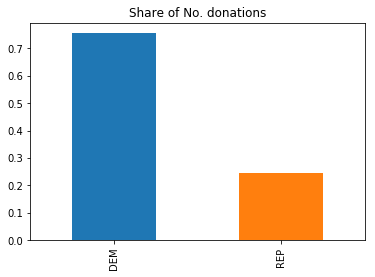

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(facecolor='w')
df.cand_pty_affiliation.value_counts(normalize=True).plot(
    kind="bar", title="Share of No. donations")
plt.show()

确实，75% 的捐款是给民主党的。我们具备的特征是捐款人、交易详情和捐款接收者的数据信息。我们使用 ROC-AUC 来评估模型性能。如果你之前没用过该指标，随机猜测可以是 0.5 分，完美的召回率和精确率是1.0。

# 3.集成算法
结合多个模型的预测，对特异性误差取平均，从而获得更好的整体预测结果

## 3.1.通过决策树来理解集成

Decision tree ROC-AUC score: 0.672


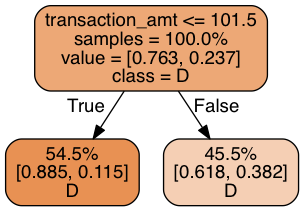

In [3]:
import pydotplus
from IPython.display import Image
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

def print_graph(clf, feature_names):
    """Print decision tree."""
    graph = export_graphviz(
        clf,
        label="root",
        proportion=True,
        impurity=False,
        out_file=None,
        feature_names=feature_names,
        class_names={0: "D", 1: "R"},
        filled=True,
        rounded=True
    )
    graph = pydotplus.graph_from_dot_data(graph)
    return Image(graph.create_png())
t1 = DecisionTreeClassifier(max_depth=1, random_state=SEED)
t1.fit(xtrain, ytrain)
p = t1.predict_proba(xtest)[:, 1]

print("Decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))
print_graph(t1, xtrain.columns)

每个叶节点记录它们在训练样本中的比例、类别分布和类别标签预测。我们的决策树根据捐款金额是否超过 101.5 进行预测：它竟然作出了同样的预测！鉴于 75% 的捐款都给了民主党，这个结果并不令人惊讶。但是这没有充分利用我们已有的数据，下面我们使用三层决策规则，看看会得到什么

Decision tree ROC-AUC score: 0.751


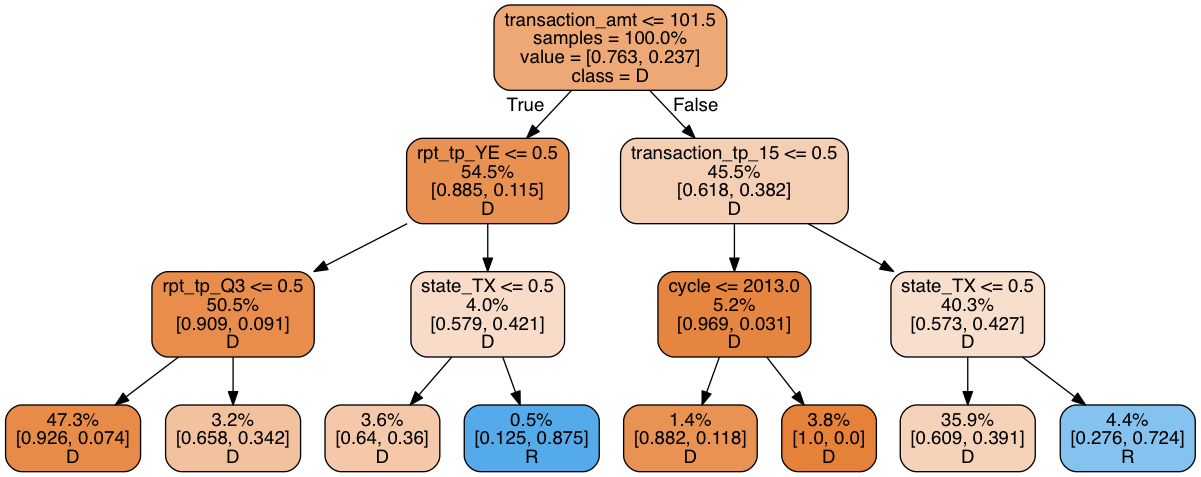

In [4]:
t2 = DecisionTreeClassifier(max_depth=3, random_state=SEED)
t2.fit(xtrain, ytrain)
p = t2.predict_proba(xtest)[:, 1]

print("Decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))
print_graph(t2, xtrain.columns)

该模型并不比简单的决策树好太多：预测到的共和党捐款金额比例只有5%，远远低于25%。仔细观察会发现该决策树使用了很多不确定的分割规则（splitting rule）。观察结果中高达47.3%的结果在最左边的叶节点中，而35.9%在右二的叶节点中。因此大量叶节点没有关联。使该模型更深只会导致过拟合。在深度固定的情况下，决策树可以通过增加「宽度」的方式来增加复杂度，即创建多个决策树，并将其连接起来。也就是决策树的集成。想了解这个集成模型为什么会起作用，先要考虑我们如何让决策树探索出比上层树更多的其他模式。最简单的解决方案就是删除树中较早出现的特征。假如我们删除了转账金额特征（transaction_amt），树的根节点，则新的决策树如下：

Decision tree ROC-AUC score: 0.740


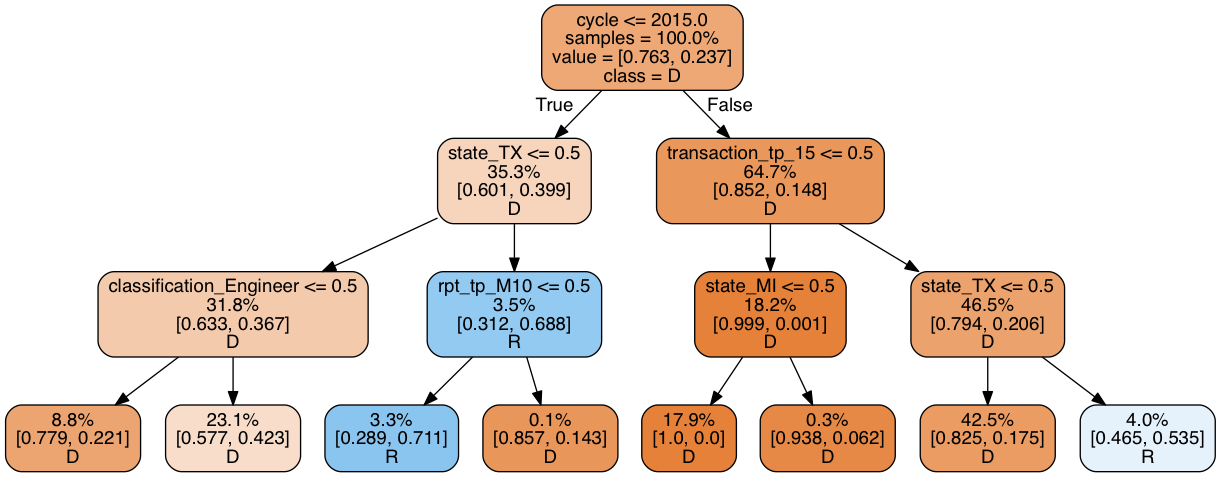

In [5]:
drop = ["transaction_amt"]
xtrain = pd.DataFrame(xtrain)
xtest = pd.DataFrame(xtest)

xtrain_slim = xtrain.drop(['transaction_amt'], 1)
xtest_slim = xtest.drop("transaction_amt", 1)

t3 = DecisionTreeClassifier(max_depth=3, random_state=SEED)
t3.fit(xtrain_slim, ytrain)
p = t3.predict_proba(xtest_slim)[:, 1]

print("Decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))
print_graph(t3, xtrain_slim.columns)

ROC-AUC 得分与上树得分类似，但是共和党捐款比例增加至 7.3%。还是很低，但比之前稍高一些。重要的是，与第一个树相反（第一个树大部分规则与转账本身相关），这棵树更专注于候选人的居住地。现在我们有两个模型，二者预测能力相近，但基于不同的规则运行。因此，它们可能出现不同的预测误差，我们可以使用集成方法取其平均数。

## 3.2.森林是树的集成
回到我们的预测问题，看看我们是否可以用两个决策树构建一个集成。首先检查误差关联性：高度关联的误差会造成差的集成。

In [6]:
p1 = t2.predict_proba(xtest)[:, 1]
p2 = t3.predict_proba(xtest_slim)[:, 1]

pd.DataFrame({"full_data": p1,
              "red_data": p2}).corr()

,full_data,red_data
full_data,1.000000,0.669128
red_data,0.669128,1.000000


有一些关联性，但不过分：预测方差仍有很大的利用空间。为了构建该集成，我们简单地平均了两个模型的预测。

In [7]:
p1 = t2.predict_proba(xtest)[:, 1]
p2 = t3.predict_proba(xtest_slim)[:, 1]
p = np.mean([p1, p2], axis=0)
print("Average of decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))

Average of decision tree ROC-AUC score: 0.783


In [8]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=10,
    max_features=3,
    random_state=SEED
)

rf.fit(xtrain, ytrain)
p = rf.predict_proba(xtest)[:, 1]
print("Average of decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))

Average of decision tree ROC-AUC score: 0.844


随机森林极大改进了我们之前的模型。但是只使用决策树可以做的事情比较有限。是时候扩展我们的视野了。

## 3.3.作为平均预测的集成
目前为止，我们看到了集成的两个重要方面：
1. 预测误差的关联性越低，效果越好
2. 模型越多，效果越好

出于这一原因，尽可能使用不同模型不失为一个好方法（只要它们表现良好）。目前为止我们一直在依赖简单的平均，但是稍后我们将了解如何使用更复杂的结合。为了记录进程，我们把集成公式化为如下：
$$e(x)=\frac{1}{n}\sum_{i=1}^nf_i(x)$$
涵盖的模型没有限制：决策树、线性模型、核模型、非参数模型、神经网络，或者甚至其他集成！记住我们包含的模型越多，集成的速度就会越慢。为了构建不同模型的集成，我们首先在数据集上对一组 Scikit-learn 分类器进行基准测试。为了避免代码重复，我们使用下面的辅助函数：

In [9]:
# A host of Scikit-learn models
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

def get_models():
    """Generate a library of base learners."""
    nb = GaussianNB()
    svc = SVC(C=100, probability=True)
    knn = KNeighborsClassifier(n_neighbors=3)
    lr = LogisticRegression(C=100, random_state=SEED)
    nn = MLPClassifier((80, 10), early_stopping=False, random_state=SEED)
    gb = GradientBoostingClassifier(n_estimators=100, random_state=SEED)
    rf = RandomForestClassifier(n_estimators=10, max_features=3, random_state=SEED)
    
    models = {'svm': svc,
              'knn': knn,
              'naive bayes': nb,
              'mlp-nn': nn,
              'random forest': rf,
              'gbm': gb,
              'logistic': lr,
              }
    
    return models


def train_predict(model_list):
    """Fit models in list on training set and return preds"""
    P = np.zeros((ytest.shape[0], len(model_list)))
    P = pd.DataFrame(P)
    
    print("Fitting models.")
    cols = list()
    for i, (name, m) in enumerate(models.items()):
        print("%s..." % name, end=" ", flush=False)
        m.fit(xtrain, ytrain)
        P.iloc[:, i] = m.predict_proba(xtest)[:, 1]
        cols.append(name)
        print("done")
    
    P.columns = cols
    print("Done.\n")
    return P


def score_models(P, y):
    """Score model in prediction DF"""
    print("Scoring models.")
    for m in P.columns:
        score = roc_auc_score(y, P.loc[:, m])
        print("%-26s: %.3f" % (m, score))
    print("Done.\n")

models = get_models()
P = train_predict(models)
score_models(P, ytest)

Fitting models.
svm... 

done
knn... 

done
naive bayes... 

done
mlp-nn... 

done
random forest... 

done
gbm... 

done
logistic... done
Done.

Scoring models.
svm                       : 0.850
knn                       : 0.779
naive bayes               : 0.803


mlp-nn                    : 0.851
random forest             : 0.844
gbm                       : 0.878
logistic                  : 0.854
Done.



这是我们的基线。梯度提升机（Gradient Boosting Machine/GBM）效果最好，其次是简单的 logistic 回归。对于我们的集成策略来说，预测误差必须是相对不关联的。

<Figure size 432x288 with 0 Axes>

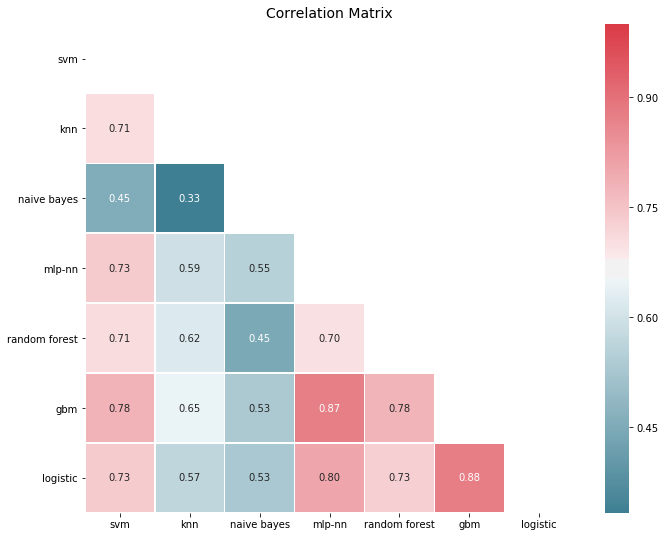

In [14]:
from mlens.visualization import corrmat

plt.figure(facecolor='w')
corrmat(P.corr(), inflate=False)
plt.show()

误差明显关联，这对于表现良好的模型是可以预期的，因为它是典型的异常值，很难纠正。然而，大多数关联性在50-80％的范围内，所以还有很大的改进余地.事实上，如果我们从类别预测的角度看误差关联性，事情看起来会更有希望：

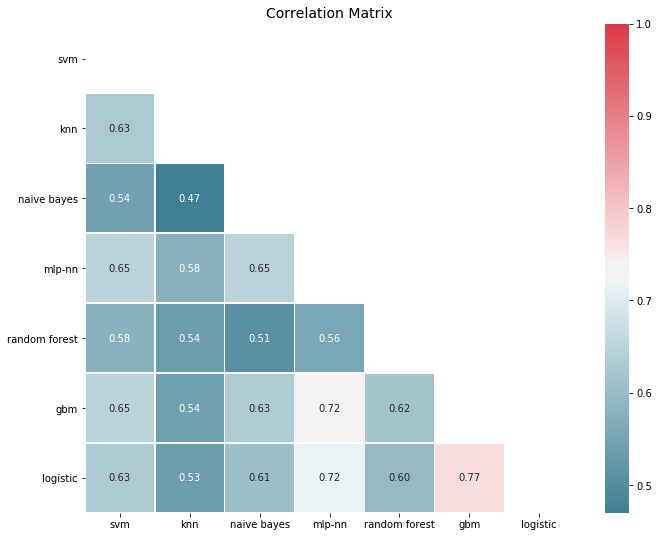

In [15]:
corrmat(P.apply(lambda pred: 1*(pred >= 0.5) - ytest.values).corr(), inflate=False)
plt.show()

为了创建集成，我们继续并进行平均预测，正如我们所期望的，集成的性能要好于基线。平均化是一个简单的过程，如果我们存储模型预测，我们可以从一个简单的集成开始，并在训练新模型时随时增加其大小。

In [16]:
print("Ensemble ROC-AUC score: %.3f" % roc_auc_score(ytest, P.mean(axis=1)))

Ensemble ROC-AUC score: 0.884


# 4.集成的实现
## 4.1.定义基学习器的库
它们是处理输入数据并生成预测的模型，可以是线性回归，也可以是神经网络，甚至可以是另一个集成。和往常一样，多样性是强大的！唯一需要注意的是，我们加入越多的模型，集成运行的速度就会越慢。在这里，我会使用此前的模型集合：

In [10]:
base_learners = get_models()

## 4.2.定义一个元学习器
应该使用哪个元学习器，人们并没有统一看法，但目前流行的选择是线性模型、基于核的模型（支持向量机和 KNN 算法）以及基于决策树的模型。你也可以使用另一个集成作为「元学习器」：在这种特殊情况下，你最终会得到一个两层的集成，这有点类似于前馈神经网络。在这里，我们会使用一个梯度提升机。为了确保GBM能够探索局部特征，我们需要限定每1000个决策树在4个基学习器的随机子集和50%的输入数据上进行训练。这样，GBM就会表达每个基学习器在不同近邻输入空间上的预测内容。

In [11]:
meta_learner = GradientBoostingClassifier(
    n_estimators=1000,
    loss="exponential",
    max_features=4,
    max_depth=3,
    subsample=0.5,
    learning_rate=0.005,
    random_state=SEED
)

## 4.3.定义步骤，生成训练和测试集
为简单起见，我们将完整训练集分为基学习器的训练集和预测集。这种方法有时被称为「混合（Blending）」。不过，不同社区之间的术语是不同的，所以知道集成使用了哪种类型的交叉验证有时并不容易。

In [12]:
xtrain_base, xpred_base, ytrain_base, ypred_base = train_test_split(
    xtrain, ytrain, test_size=0.5, random_state=SEED)

## 4.4.在训练集上训练基学习器
为在训练数据上训练基学习器，我们照常运行：

In [13]:
def train_base_learners(base_learners, inp, out, verbose=True):
    """Train all base learners in the library."""
    if verbose: 
        print("Fitting models.")
    for i, (name, m) in enumerate(base_learners.items()):
        if verbose: print("%s..." % name, end=" ", flush=False)
    m.fit(inp, out)
    if verbose: 
        print("done")
train_base_learners(base_learners, xtrain_base, ytrain_base)

Fitting models.
svm... knn... naive bayes... mlp-nn... random forest... gbm... logistic... done


## 4.5.生成基学习器预测
基学习器拟合后，我们现在可以生成一系列预测用于训练元学习器。注意，我们生成的基于观测值的预测并不会用于基学习器的训练，对于每个观测：
$$x_{pred}^{(i)} \in X_{pred\_base}$$
在基学习器预测集中，我们生成了基学习器预测结果的集合：
$$p_{base}^{(i)}=[f_1x_{pred}^{(i)},...,f_nx_{pred}^{(i)}]$$
如果你实现自己的集成，请特别注意如何索引预测矩阵的行和列——将数据分成两个部分并不难，但对于后来的交叉验证就很有挑战性了。

In [15]:
def predict_base_learners(pred_base_learners, inp, verbose=True):
    """Generate a prediction matrix."""
    P = np.zeros((inp.shape[0], len(pred_base_learners)))
    
    if verbose: 
        print("Generating base learner predictions.")
    for i, (name, m) in enumerate(pred_base_learners.items()):
        if verbose: 
            print("%s..." % name, end=" ", flush=False)
    p = m.predict_proba(inp)
    # With two classes, need only predictions for one class
    P[:, i] = p[:, 1]
    if verbose:
        print("done")
    
    return P

P_base = predict_base_learners(base_learners, xpred_base)

Generating base learner predictions.
svm... knn... naive bayes... mlp-nn... random forest... gbm... logistic... done


## 4.6.训练元学习器
预测矩阵 P_base 反映了测试时间的性能，可被用于训练元学习器：

In [16]:
meta_learner.fit(P_base, ypred_base)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.005, loss='exponential', max_depth=3,
              max_features=4, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              presort='auto', random_state=222, subsample=0.5, verbose=0,
              warm_start=False)

In [17]:
def ensemble_predict(base_learners, meta_learner, inp, verbose=True):
    """Generate predictions from the ensemble."""
    P_pred = predict_base_learners(base_learners, inp, verbose=verbose)
    return P_pred, meta_learner.predict_proba(P_pred)[:, 1]
P_pred, p = ensemble_predict(base_learners, meta_learner, xtest)
print("\nEnsemble ROC-AUC score: %.3f" % roc_auc_score(ytest, p))

Generating base learner predictions.
svm... knn... naive bayes... mlp-nn... random forest... gbm... logistic... 

done



Ensemble ROC-AUC score: 0.849
